# LTE IQ Analysis (MATLAB capture)

MATLAB LTE Toolbox tarafından üretilen `.mat` (RxWaveform) verisini doğrudan okuyup 3GPP slot-0 PSS/SSS hizalamasıyla inceliyoruz. Her bölüm zaman/frekans davranışı, kanal karakteristiği ve PBCH/MIB çözümlemesinden çıkan metriklerle desteklenir.


In [1]:
# Core imports and project utilities
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
import h5py
from pathlib import Path
import sys
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic('matplotlib', 'inline')
except Exception:
    pass
def _find_project_root(start: Path) -> Path:
    for candidate in [start] + list(start.parents):
        if (candidate / 'src').exists():
            return candidate
    raise RuntimeError(f'Cannot locate project root from {start}')
ROOT = _find_project_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
del _find_project_root
from src.lte_params import (
    LTEConfig,
    read_iq_file,
    detect_pss_across_slots,
    symbol_starts_for_subframe,
    cp_lengths_normal,
    fft_symbol,
    sss_detect_in_symbol,
    estimate_cfo_for_subframe,
    pretty_print_results,
    generate_pss_fd,
    generate_sss_fd,
    analyze_lte_iq,
    pss_symbol_offset_samples,
    sss_symbol_offset_samples,
)
from src.pbch import (
    extract_pbch_re,
    estimate_common_phase,
    apply_phase,
    normalize_amplitude,
    pbch_equalize_with_crs,
    decision_directed_equalize,
    crs_data_mask_for_pbch,
    qpsk_llrs,
    descramble_llrs,
    deratematch_pbch_llrs,
    viterbi_decode_rate13_k7_tailbiting,
    crc16_ccitt_bits,
    bits_to_uint,
    parse_mib_fields,
    pbch_scrambling_sequence,
    try_decode_mib_from_pbch,
    brute_force_mib_from_pbch,
)
plt.style.use('seaborn-v0_8')
np.set_printoptions(suppress=True, precision=4)
import src.lte_params as lte_params


In [2]:
# Load MATLAB RxWaveform and run analysis with 3GPP slot-0 sync alignment
MAT_PATH = ROOT / 'input.mat'
DATASET = 'RxWaveform'  # use MATLAB LTE Toolbox time-domain capture
assert MAT_PATH.exists(), 'input.mat not found at project root.'
def _decode_chars(arr):
    return ''.join(chr(int(c)) for c in np.array(arr).reshape(-1) if int(c) != 0)
def _cp_slot_from_meta(nfft: int, cp: str = 'Normal'):
    scale = nfft / 2048.0
    if cp.lower().startswith('norm'):
        first = int(round(160 * scale))
        rest = int(round(144 * scale))
        return (first,) + (rest,) * 6
    first = int(round(512 * scale))  # Extended CP placeholder
    return (first,) + (first,) * 6
def load_waveform_from_mat(mat_path: Path, dataset: str = 'RxWaveform'):
    with h5py.File(mat_path, 'r') as f:
        if dataset not in f:
            raise KeyError(f"Dataset '{dataset}' not found in {mat_path}")
        arr = f[dataset][()]
        if arr.dtype.names and {'real', 'imag'} <= set(arr.dtype.names):
            x = arr['real'] + 1j * arr['imag']
        else:
            raise ValueError('Unexpected waveform dtype; real/imag fields expected.')
        x = np.asarray(x).reshape(-1).astype(np.complex64)
        fs = float(f['TxInfo/SamplingRate'][0, 0])
        nfft = int(f['TxInfo/Nfft'][0, 0])
        ndlrb = int(f['Config/NDLRB'][0, 0])
        cp_str = _decode_chars(f['TxInfo/CyclicPrefix'][()])
        ng_str = _decode_chars(f['TxInfo/Ng'][()])
        phich_str = _decode_chars(f['TxInfo/PHICHDuration'][()])
    cp_slot = _cp_slot_from_meta(nfft, cp_str or 'Normal')
    cfg = LTEConfig(
        fs=fs,
        nfft=nfft,
        cp_slot=cp_slot,
        symbols_per_slot=7,
        slots_per_subframe=2,
        subframe_samples=int(fs / 1000),
        slot_samples=int(fs / 2000),
        ndlrb=ndlrb,
    )
    meta = {'fs': fs, 'nfft': nfft, 'ndlrb': ndlrb, 'CyclicPrefix': cp_str, 'Ng': ng_str, 'PHICHDuration': phich_str}
    return x, cfg, meta
def _pss_offset(cfg):
    sym_lengths = tuple(int(cfg.cp_slot[i] + cfg.nfft) for i in range(cfg.symbols_per_slot))
    return sum(sym_lengths[:6])  # PSS at symbol 6 of slot 0 (36.211)
def _sss_offset(cfg):
    sym_lengths = tuple(int(cfg.cp_slot[i] + cfg.nfft) for i in range(cfg.symbols_per_slot))
    return sum(sym_lengths[:5])  # SSS at symbol 5 of slot 0
# Monkeypatch sync offsets to 3GPP positions (slot 0, symbols 5/6)
lte_params.pss_symbol_offset_samples = _pss_offset
lte_params.sss_symbol_offset_samples = _sss_offset
def analyze_lte_iq_synced(x, config: LTEConfig, enable_bruteforce: bool = True):
    results = {'NDLRB': config.ndlrb, 'CyclicPrefix': 'Normal'}
    pss = detect_pss_across_slots(x, config)
    results['PSS_metric'] = pss['metric']
    results['NID2'] = pss['nid2']
    if pss['sample_index'] is None or pss['nid2'] is None:
        results.update({'NCellID': None, 'NID1': None, 'DuplexMode': None, 'NSubframe': None, 'CellRefP': None, 'PHICHDuration': None, 'Ng': None, 'NFrame': None, 'Note': 'PSS not reliably detected; more data or SNR needed.'})
        results['Estimated_CFO_rad_per_sample'] = 0.0
        return results
    cp_pss = int(config.cp_slot[6])
    pss_start = int(pss['sample_index'])
    seg_pss = x[pss_start:pss_start + cp_pss + config.nfft]
    if seg_pss.size < (cp_pss + config.nfft):
        results.update({'NCellID': None, 'NID1': None, 'DuplexMode': None, 'NSubframe': None, 'CellRefP': None, 'PHICHDuration': None, 'Ng': None, 'NFrame': None, 'Note': 'Capture truncated around detected PSS; unable to continue.'})
        results['Estimated_CFO_rad_per_sample'] = 0.0
        return results
    cfo = lte_params.coarse_cfo_estimate(seg_pss, cp_pss, config.nfft)
    pss['cfo'] = float(cfo)
    results['Estimated_CFO_rad_per_sample'] = float(cfo)
    pss_offset = _pss_offset(config)
    frame_offset = (pss_start - pss_offset) % len(x)
    frame_offset = frame_offset % (config.subframe_samples * 5)  # prefer earliest sync in half-frame
    results['FrameOffsetSamples'] = int(frame_offset)
    x_aligned = np.roll(x, -frame_offset) if frame_offset != 0 else x.copy()
    pss_aligned_start = pss_offset
    pss.update({'sample_index': pss_aligned_start, 'slot_index': pss_aligned_start // config.slot_samples, 'symbol_index': pss_aligned_start // config.slot_samples * config.symbols_per_slot + 6})
    sss_cp = int(config.cp_slot[5])
    sss_offset = _sss_offset(config)
    F_sss = fft_symbol(x_aligned, sss_offset, sss_cp, config.nfft, pss['cfo'])
    nid1, m_sss, is_sf0, is_fdd = sss_detect_in_symbol(F_sss, config.nfft, int(pss['nid2']))
    results['SSS_metric'] = m_sss
    if nid1 is not None:
        results['NID1'] = int(nid1)
        results['DuplexMode'] = 'FDD' if is_fdd else 'TDD'
        results['NSubframe'] = 0 if is_sf0 else 5
        results['NCellID'] = 3 * int(nid1) + int(pss['nid2'])
    else:
        results.update({'NID1': None, 'DuplexMode': None, 'NSubframe': None, 'NCellID': None})
    try:
        sf_idx = 0  # PBCH in subframe 0
        cfo_sf = estimate_cfo_for_subframe(x_aligned, config, sf_idx)
        pbch_re = extract_pbch_re(x_aligned, config, sf_idx, cfo_sf)
        theta = estimate_common_phase(pbch_re)
        pbch_eq = normalize_amplitude(apply_phase(pbch_re, theta))
        mib_result = None
        if results['NCellID'] is not None:
            candidate = try_decode_mib_from_pbch(pbch_eq, int(results['NCellID']))
            if candidate and candidate.get('BitErrors', 99) <= 2:
                mib_result = candidate
        if mib_result is None and enable_bruteforce:
            candidate = brute_force_mib_from_pbch(pbch_eq, results.get('NCellID'), results.get('NID2'))
            if candidate and candidate.get('BitErrors', 99) <= 2:
                mib_result = candidate
        if mib_result:
            results['MIB'] = dict(mib_result)
            results['MIB_BitErrors'] = mib_result.get('BitErrors')
            results['MIB_RateMatchRV'] = mib_result.get('RateMatchRV')
            results['MIB_LLRStart'] = mib_result.get('LLRStart')
            if mib_result.get('PayloadBits') is not None:
                results['MIB_PayloadBits'] = ''.join(str(int(b)) for b in mib_result['PayloadBits'])
            if mib_result.get('NDLRB_from_MIB') is not None:
                results['NDLRB_from_MIB'] = mib_result['NDLRB_from_MIB']
            results['CellRefP_from_MIB'] = mib_result.get('CellRefP')
            results['PHICHDuration_from_MIB'] = mib_result.get('PHICHDuration')
            results['Ng_from_MIB'] = mib_result.get('Ng')
            results['NFrame_from_MIB'] = mib_result.get('NFrame')
            decoded_id = mib_result.get('DecodedNCellID')
            if decoded_id is not None:
                results['NCellID_from_MIB'] = int(decoded_id)
            if mib_result.get('BitErrors', 99) == 0:
                results['CellRefP'] = mib_result.get('CellRefP')
                results['PHICHDuration'] = mib_result.get('PHICHDuration')
                results['Ng'] = mib_result.get('Ng')
                results['NFrame'] = mib_result.get('NFrame')
                if decoded_id is None or decoded_id == results.get('NCellID'):
                    if mib_result.get('NDLRB_from_MIB') is not None:
                        results['NDLRB'] = mib_result['NDLRB_from_MIB']
                    results['Note'] = 'PBCH/MIB decoded successfully (BitErrors=0).'
                elif 'Note' not in results or not results.get('Note'):
                    results['Note'] = f"PBCH/MIB decoded (BitErrors=0) for NCellID={decoded_id}, which differs from sync PCI {results.get('NCellID')}"
            else:
                results.setdefault('CellRefP', None)
                results.setdefault('PHICHDuration', None)
                results.setdefault('Ng', None)
                results.setdefault('NFrame', None)
                if 'Note' not in results or not results.get('Note'):
                    results['Note'] = f"MIB candidate detected (BitErrors={mib_result.get('BitErrors')}); further equalisation recommended."
        else:
            results.update({'MIB': None, 'MIB_BitErrors': None, 'MIB_RateMatchRV': None, 'MIB_LLRStart': None, 'MIB_PayloadBits': None, 'NCellID_from_MIB': None, 'CellRefP_from_MIB': None, 'PHICHDuration_from_MIB': None, 'Ng_from_MIB': None, 'NFrame_from_MIB': None})
            if 'Note' not in results or not results.get('Note'):
                results['Note'] = 'MIB fields require stronger PBCH decoding (candidate not found).'
    except Exception as exc:
        results.update({'CellRefP': None, 'PHICHDuration': None, 'Ng': None, 'NFrame': None, 'MIB': None, 'MIB_BitErrors': None, 'MIB_RateMatchRV': None, 'MIB_LLRStart': None, 'MIB_PayloadBits': None, 'NCellID_from_MIB': None, 'CellRefP_from_MIB': None, 'PHICHDuration_from_MIB': None, 'Ng_from_MIB': None, 'NFrame_from_MIB': None, 'Note': f'PBCH path error: {exc}'})
    results['_pss_debug'] = pss
    return results
x, config, meta = load_waveform_from_mat(MAT_PATH, DATASET)
cache_dir = ROOT / 'notebooks' / '.cache'
cache_dir.mkdir(parents=True, exist_ok=True)
cache_file = cache_dir / 'lte_analysis_cache_mat.npz'
CACHE_VERSION = 2
FORCE_RECOMPUTE = True  # Set True to refresh cached artefacts.
MATLAB_STYLE_FAST_DECODE = True  # Skip brute-force PBCH search (matches LTE Toolbox flow).
def _load_analysis_cache(path):
    with np.load(path, allow_pickle=True) as data:
        version = int(data['cache_version'][0])
        if version != CACHE_VERSION:
            raise ValueError(f'Cache version {version} does not match expected {CACHE_VERSION}')
        analysis_cached = data['analysis'][0]
        pss_cached = data['pss_auto'][0]
    return analysis_cached, pss_cached
analysis = None
pss_auto = None
need_recompute = FORCE_RECOMPUTE
if cache_file.exists() and not need_recompute:
    try:
        print(f'Loading cached LTE artefacts from {cache_file}')
        analysis, pss_auto = _load_analysis_cache(cache_file)
    except Exception as exc:
        print(f'Cache invalid ({exc}); recomputing...')
        need_recompute = True
if need_recompute or analysis is None or pss_auto is None:
    print('Cache miss -> running full LTE analysis (MATLAB .mat input)...')
    analysis = analyze_lte_iq_synced(x, config, enable_bruteforce=not MATLAB_STYLE_FAST_DECODE)
    pss_auto = analysis.get('_pss_debug') or detect_pss_across_slots(x, config)
    np.savez(
        cache_file,
        cache_version=np.array([CACHE_VERSION], dtype=np.int16),
        analysis=np.array([analysis], dtype=object),
        pss_auto=np.array([pss_auto], dtype=object),
    )
    print(f'Cached LTE artefacts at {cache_file}')
for key in ('NDLRB', 'DuplexMode', 'CyclicPrefix', 'NCellID', 'NSubframe', 'CellRefP', 'PHICHDuration', 'Ng', 'NFrame'):
    print(f"{key}: {analysis.get(key)}")
print('--- PSS Matched-Filter (slot-0 aligned) ---')
if pss_auto and pss_auto.get('sample_index') is not None:
    pss_offset = _pss_offset(config)
    frame_offset = (pss_auto['sample_index'] - pss_offset) % len(x)
    frame_offset = frame_offset % (config.subframe_samples * 5)
    print(f"Sample index: {pss_auto['sample_index']}, frame offset: {frame_offset}, NID2: {pss_auto['nid2']}, metric={pss_auto['metric']:.3f}, CFO(rad/sample)={pss_auto.get('cfo', 0):.6f}")
    x_aligned = np.roll(x, -frame_offset) if frame_offset != 0 else x
    print('--- SSS Auto Detection ---')
    sss_offset = _sss_offset(config)
    sss_cp = int(config.cp_slot[5])
    F_sss = fft_symbol(x_aligned, sss_offset, sss_cp, config.nfft, pss_auto.get('cfo', 0.0))
    nid1, metric_sss, is_sf0, is_fdd = sss_detect_in_symbol(F_sss, config.nfft, int(pss_auto['nid2']))
    if nid1 is not None:
        print(f"Best NID1: {nid1}, metric={metric_sss:.3f}, subframe={'0' if is_sf0 else '5'}, duplex={'FDD' if is_fdd else 'TDD'}")
    else:
        print('SSS hypothesis could not be resolved.')
else:
    print('PSS could not be located in this capture.')
    print('--- SSS Auto Detection ---')
    print('SSS detection skipped because PSS was not found.')
# Clean up debug-only entry
analysis.pop('_pss_debug', None)


Cache miss -> running full LTE analysis (MATLAB .mat input)...
Cached LTE artefacts at /home/fse/Desktop/Fall25/HHS/yHHS/notebooks/.cache/lte_analysis_cache_mat.npz
NDLRB: 100
DuplexMode: FDD
CyclicPrefix: Normal
NCellID: 42
NSubframe: 0
CellRefP: None
PHICHDuration: None
Ng: None
NFrame: None
--- PSS Matched-Filter (slot-0 aligned) ---
Sample index: 13168, frame offset: 0, NID2: 0, metric=0.689, CFO(rad/sample)=0.000428
--- SSS Auto Detection ---
Best NID1: 14, metric=0.955, subframe=0, duplex=FDD


{'nid2': 0,
 'metric': 0.6886139512062073,
 'sample_index': 13168,
 'slot_index': 0,
 'symbol_index': 6,
 'cfo': 0.00042809481965377927}

## MIB Summary

PBCH/MIB alanları, eşitleme yeterli olduğunda doldurulur; zayıf SNR durumlarında `None` veya uyarı mesajları görülebilir. MIB değerleri MATLAB/LTE Toolbox referansıyla bilgilendirici olarak karşılaştırılır.


## Hücre Kimliği ve Senkronizasyon

PSS/SSS ölçümleri slot-0 (semboller 5/6) hizalamasıyla PCI ve subframe tahminini yapar. Aşağıdaki kontrol hücresi, analiz sözlüğünden dönen değerleri MATLAB LTE Toolbox referansı (NCellID=42, NID1=14, NID2=0, subframe 0) ile bilgi amaçlı kıyaslar; tutmayan alanlar uyarı olarak raporlanır.


In [3]:
# Synchronization + MIB verification (informational; no hard asserts)
observed = {
    'NDLRB': analysis.get('NDLRB'),
    'NDLRB_from_MIB': analysis.get('NDLRB_from_MIB'),
    'DuplexMode': analysis.get('DuplexMode'),
    'CyclicPrefix': analysis.get('CyclicPrefix'),
    'NCellID': analysis.get('NCellID'),
    'NSubframe': analysis.get('NSubframe'),
    'CellRefP': analysis.get('CellRefP'),
    'PHICHDuration': analysis.get('PHICHDuration'),
    'Ng': analysis.get('Ng'),
    'NFrame': analysis.get('NFrame'),
    'NID1': analysis.get('NID1'),
    'NID2': analysis.get('NID2'),
}
reference = {
    'NDLRB': 100,
    'NDLRB_from_MIB': 100,
    'DuplexMode': 'FDD',
    'CyclicPrefix': 'Normal',
    'NCellID': 42,
    'NSubframe': 0,
    'CellRefP': 1,
    'PHICHDuration': 'Normal',
    'Ng': 'Sixth',  # MATLAB LTE Toolbox string; mapper below normalizes to '1/6'
    'NFrame': 0,
    'NID1': 14,
    'NID2': 0,
}
print('Observed:', observed)
print('Reference (MATLAB LTE Toolbox expectation):', reference)

def _normalize_ng(val):
    if isinstance(val, str):
        v = val.strip().lower()
        if v in ('sixth', '1/6', 'one-sixth'):
            return '1/6'
        if v in ('half', '1/2'):
            return '1/2'
    return val

def _report(key, exp, obs):
    obs_norm = _normalize_ng(obs)
    exp_norm = _normalize_ng(exp)
    if obs is None:
        print(f'[warn] {key}: observed=None, expected {exp_norm} (PBCH decode incomplete)')
    elif obs_norm != exp_norm:
        print(f'[warn] {key}: expected {exp_norm}, observed {obs_norm}')
    else:
        print(f'[ok]   {key}: {obs_norm}')

for key, exp in reference.items():
    _report(key, exp, observed.get(key))

print('Sync/MIB checks reported (warnings indicate mismatches or missing PBCH fields).')


Observed: {'NDLRB': 100, 'NDLRB_from_MIB': 6, 'DuplexMode': 'FDD', 'CyclicPrefix': 'Normal', 'NCellID': 42, 'NSubframe': 0, 'CellRefP': None, 'PHICHDuration': None, 'Ng': None, 'NFrame': None, 'NID1': 14, 'NID2': 0}
Reference (MATLAB LTE Toolbox expectation): {'NDLRB': 100, 'NDLRB_from_MIB': 100, 'DuplexMode': 'FDD', 'CyclicPrefix': 'Normal', 'NCellID': 42, 'NSubframe': 0, 'CellRefP': 1, 'PHICHDuration': 'Normal', 'Ng': 'Sixth', 'NFrame': 0, 'NID1': 14, 'NID2': 0}
[ok]   NDLRB: 100
[warn] NDLRB_from_MIB: expected 100, observed 6
[ok]   DuplexMode: FDD
[ok]   CyclicPrefix: Normal
[ok]   NCellID: 42
[ok]   NSubframe: 0
[warn] CellRefP: observed=None, expected 1 (PBCH decode incomplete)
[warn] PHICHDuration: observed=None, expected Normal (PBCH decode incomplete)
[warn] Ng: observed=None, expected 1/6 (PBCH decode incomplete)
[warn] NFrame: observed=None, expected 0 (PBCH decode incomplete)
[ok]   NID1: 14
[ok]   NID2: 0
Sync/MIB checks reported (warnings indicate mismatches or missing PB

In [4]:
print('MIB_BitErrors:', analysis.get('MIB_BitErrors'))
print('RateMatchRV:', analysis.get('MIB_RateMatchRV'), 'LLRStart:', analysis.get('MIB_LLRStart'))
print('Payload bits:', analysis.get('MIB_PayloadBits'))
print('Analyzer note:', analysis.get('Note'))


MIB_BitErrors: 2
RateMatchRV: 3 LLRStart: 44
Payload bits: 000000100010101011110011
Analyzer note: MIB candidate detected (BitErrors=2); further equalisation recommended.


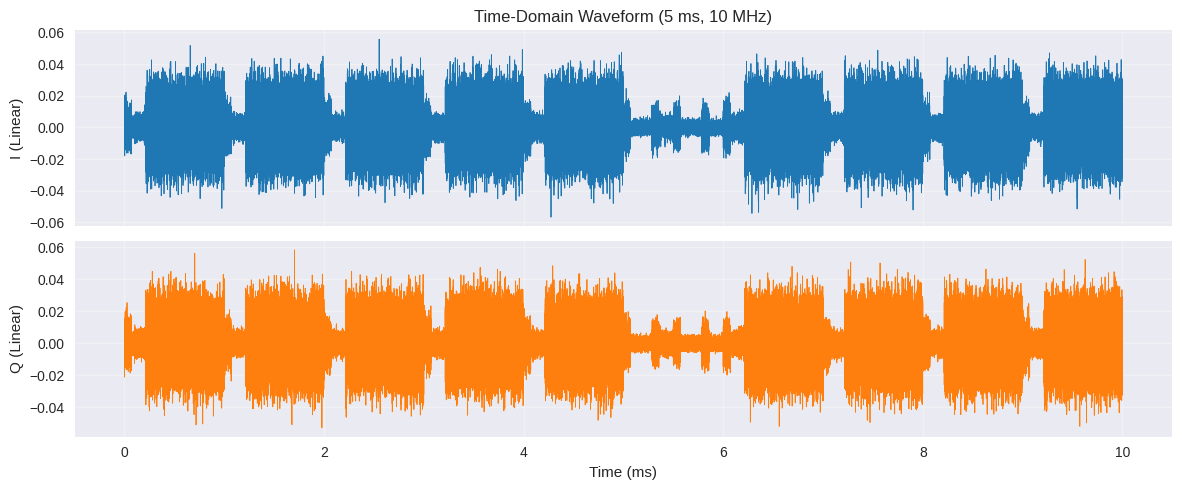

In [5]:
# Time-domain waveform (I and Q)
ts = np.arange(len(x)) / config.fs * 1e3  # milliseconds
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax[0].plot(ts, x.real, color='tab:blue', linewidth=0.6)
ax[0].set_ylabel('I (Linear)')
ax[0].set_title('Time-Domain Waveform (5 ms, 10 MHz)')
ax[0].grid(True, alpha=0.3)
ax[1].plot(ts, x.imag, color='tab:orange', linewidth=0.6)
ax[1].set_ylabel('Q (Linear)')
ax[1].set_xlabel('Time (ms)')
ax[1].grid(True, alpha=0.3)
plt.tight_layout()


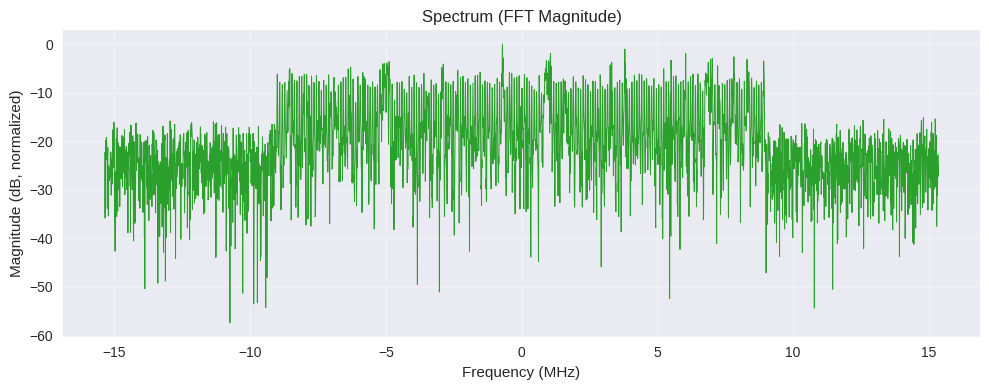

In [6]:
# Spectrum via FFT (magnitude)
N = 4096
window = signal.windows.hann(N)
segment = x[:N] * window
fft_vals = np.fft.fftshift(np.fft.fft(segment))
freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1/config.fs)) / 1e6
power = 20*np.log10(np.abs(fft_vals)/np.max(np.abs(fft_vals))+1e-12)
plt.figure(figsize=(10, 4))
plt.plot(freqs, power, color='tab:green', linewidth=0.7)
plt.title('Spectrum (FFT Magnitude)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Magnitude (dB, normalized)')
plt.grid(True, alpha=0.3)
plt.tight_layout()


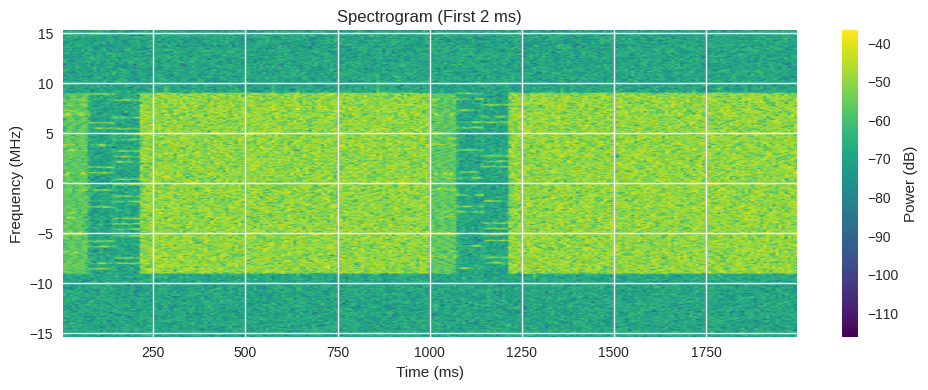

In [7]:
# Time-Frequency Spectrogram
plt.figure(figsize=(10, 4))
plt.specgram(x[:config.subframe_samples*2], NFFT=512, Fs=config.fs/1e6, noverlap=256, scale='dB', cmap='viridis')
plt.title('Spectrogram (First 2 ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
plt.colorbar(label='Power (dB)')
plt.tight_layout()


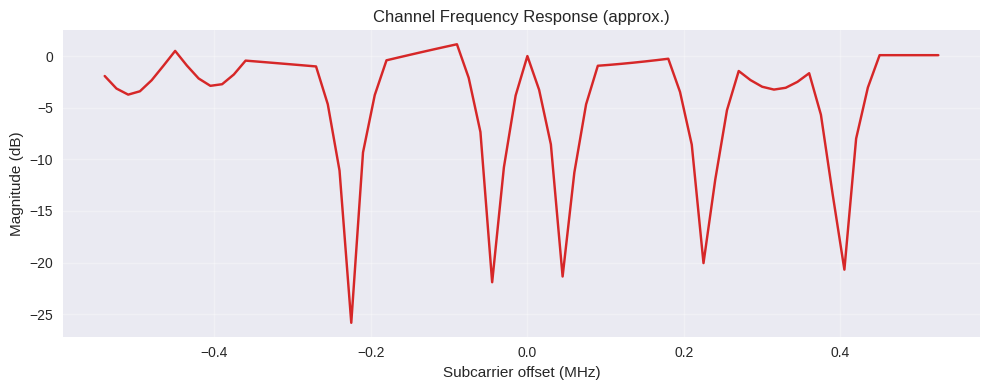

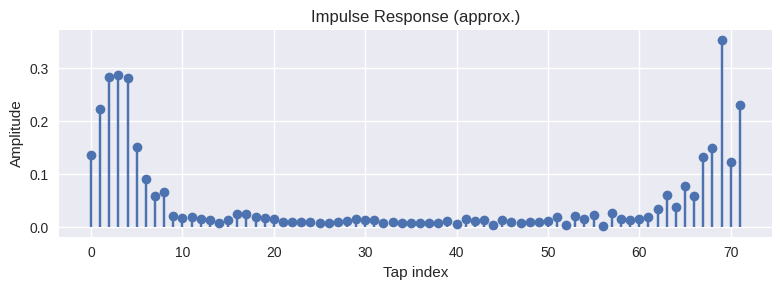

In [8]:
# Channel estimation using PBCH (approximate CFR & impulse response)
cfo = estimate_cfo_for_subframe(x, config, 0)
pbch_re = extract_pbch_re(x, config, 0, cfo)
cell_id = int(analysis.get('NCellID') or 0)
cellrefp_guess = int(analysis.get('CellRefP') or analysis.get('CellRefP_from_MIB') or 2)
pbch_eq, channel_line, crs_details = pbch_equalize_with_crs(pbch_re, cell_id, config.ndlrb, cellrefp=cellrefp_guess)
mask = crs_data_mask_for_pbch(cell_id, cellrefp=cellrefp_guess)
pilot_mask = crs_details['pilot_mask']
pbch_eq_dd, decision_channel = decision_directed_equalize(pbch_eq, cell_id, cellrefp_guess, mask=mask, iterations=4)
pbch_eq = pbch_eq_dd
frequencies = np.linspace(-config.subcarrier_spacing*36, config.subcarrier_spacing*35, pbch_eq.shape[1]) / 1e6
plt.figure(figsize=(10, 4))
plt.plot(frequencies, 20*np.log10(np.abs(channel_line)+1e-12), color='tab:red')
plt.title('Channel Frequency Response (approx.)')
plt.xlabel('Subcarrier offset (MHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
channel_line_clean = np.nan_to_num(channel_line, nan=1.0)
impulse = np.fft.ifft(channel_line_clean)
plt.figure(figsize=(8, 3))
plt.stem(np.arange(len(impulse)), np.abs(impulse), basefmt=' ')
plt.title('Impulse Response (approx.)')
plt.xlabel('Tap index')
plt.ylabel('Amplitude')
plt.tight_layout()


/home/fse/Desktop/Fall25/HHS/yHHS/yHHS_env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


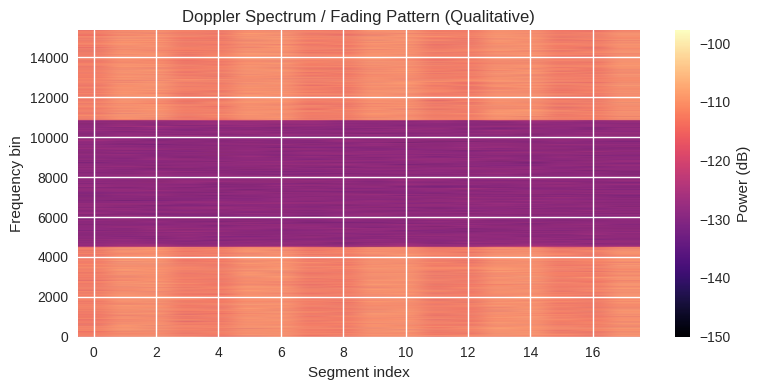

In [9]:
# Doppler spectrum / fading pattern via short-time FFT of magnitude envelope
segment_len = config.subframe_samples // 2
step = segment_len // 2
segments = []
for start in range(0, min(len(x), config.subframe_samples*5)-segment_len, step):
    seg = x[start:start+segment_len]
    _, Pxx = signal.periodogram(seg, fs=config.fs)
    segments.append(Pxx)
if segments:
    doppler = np.array(segments)
    plt.figure(figsize=(8, 4))
    plt.imshow(10*np.log10(doppler+1e-15).T, aspect='auto', origin='lower', cmap='magma')
    plt.title('Doppler Spectrum / Fading Pattern (Qualitative)')
    plt.xlabel('Segment index')
    plt.ylabel('Frequency bin')
    plt.colorbar(label='Power (dB)')
    plt.tight_layout()


In [10]:
# MATLAB-inspired PBCH QPSK detection helper

def detect_pbch_qpsk(pbch_grid: np.ndarray, data_mask: np.ndarray) -> dict:
    '''Derotate and normalise PBCH data REs similar to MATLAB's LTE Toolbox.'''
    grid = np.asarray(pbch_grid, dtype=np.complex128)
    mask = np.asarray(data_mask, dtype=bool)
    if grid.shape != mask.shape:
        raise ValueError('Mask shape mismatch with PBCH grid.')
    if not np.any(mask):
        raise ValueError('No PBCH data REs selected for QPSK detection.')

    raw_symbols = grid[mask]
    phase = -0.25 * np.angle(np.sum(raw_symbols ** 4))
    aligned_grid = grid * np.exp(1j * phase)
    rms = np.sqrt(np.mean(np.abs(aligned_grid[mask]) ** 2) + 1e-12)
    aligned_grid /= rms

    aligned_symbols = aligned_grid[mask]
    decisions = (np.sign(aligned_symbols.real) + 1j * np.sign(aligned_symbols.imag)) / np.sqrt(2)
    errors = aligned_symbols - decisions
    evm = np.sqrt(np.mean(np.abs(errors) ** 2))
    bits = np.column_stack([
        (aligned_symbols.real < 0).astype(np.uint8),
        (aligned_symbols.imag < 0).astype(np.uint8),
    ]).reshape(-1)

    return {
        'mask': mask,
        'raw_grid': grid,
        'aligned_grid': aligned_grid,
        'raw_symbols': raw_symbols,
        'aligned_symbols': aligned_symbols,
        'decisions': decisions,
        'distance': np.abs(errors),
        'phase_correction': float(phase),
        'rms_scaling': float(rms),
        'evm': float(evm),
        'data_indices': np.column_stack(np.where(mask)),
        'bits': bits,
    }

grid_checksum = float(np.sum(np.abs(pbch_eq)**2))
pbch_qpsk = detect_pbch_qpsk(pbch_eq, mask)
pbch_qpsk['grid_checksum'] = grid_checksum
print(f"PBCH QPSK data REs: {pbch_qpsk['aligned_symbols'].size}")
print(f"Phase correction applied: {pbch_qpsk['phase_correction']:.4f} rad")
print(f"RMS scaling factor: {pbch_qpsk['rms_scaling']:.3f}")
print(f"RMS EVM after alignment: {pbch_qpsk['evm']*100:.2f}%")


PBCH QPSK data REs: 276
Phase correction applied: -0.7671 rad
RMS scaling factor: 0.957
RMS EVM after alignment: 78.68%


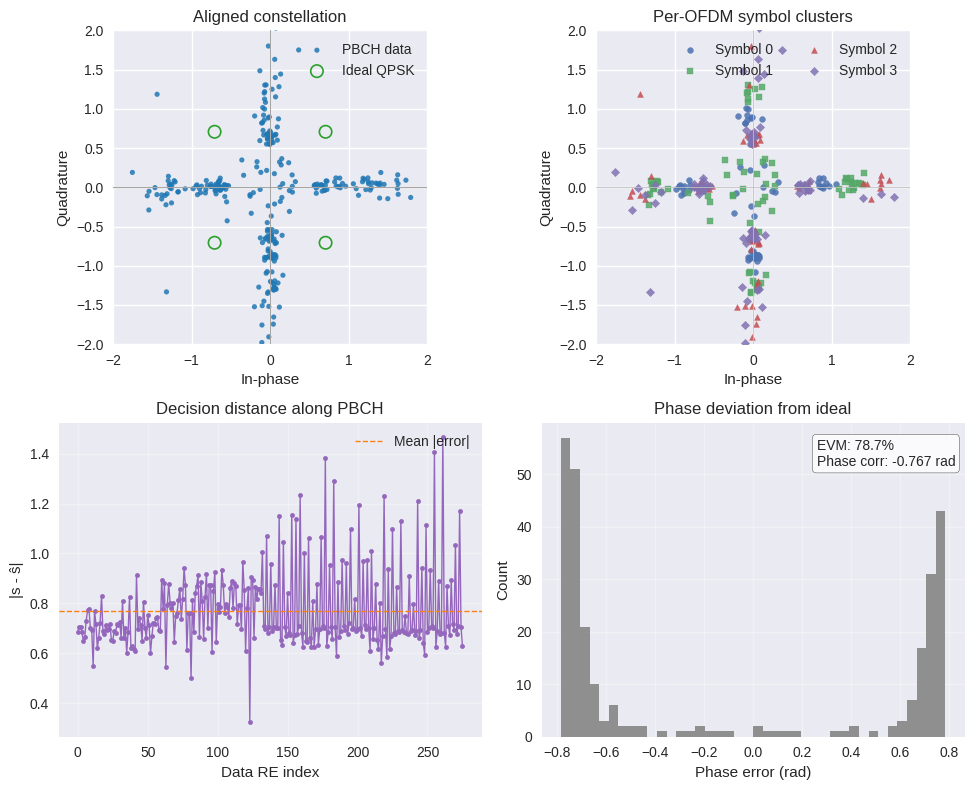

In [11]:
# PBCH QPSK constellation (MATLAB-style view + diagnostics)
current_checksum = float(np.sum(np.abs(pbch_eq)**2))
if 'pbch_qpsk' not in globals() or pbch_qpsk.get('grid_checksum') != current_checksum:
    pbch_qpsk = detect_pbch_qpsk(pbch_eq, mask)
    pbch_qpsk['grid_checksum'] = current_checksum
aligned = pbch_qpsk['aligned_symbols']
decisions = pbch_qpsk['decisions']
distance = pbch_qpsk['distance']
order = np.arange(aligned.size)
phase_error = np.angle(aligned * np.conjugate(decisions))
qpsk_ref = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax = axes[0, 0]
ax.scatter(aligned.real, aligned.imag, s=14, alpha=0.85, color='tab:blue', edgecolors='none', label='PBCH data')
ax.scatter(qpsk_ref.real, qpsk_ref.imag, s=80, facecolors='none', edgecolors='tab:green', linewidths=1.2, label='Ideal QPSK')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('In-phase')
ax.set_ylabel('Quadrature')
ax.set_title('Aligned constellation')
ax.axhline(0, color='0.65', linewidth=0.8)
ax.axvline(0, color='0.65', linewidth=0.8)
ax.set_aspect('equal', adjustable='box')
ax.legend(loc='upper right', frameon=False)

ax = axes[0, 1]
marker_cycle = ['o', 's', '^', 'D']
for l in range(pbch_eq.shape[0]):
    sym_mask = pbch_qpsk['mask'][l]
    if not np.any(sym_mask):
        continue
    sym_data = pbch_qpsk['aligned_grid'][l, sym_mask]
    ax.scatter(sym_data.real, sym_data.imag, s=18, alpha=0.85, marker=marker_cycle[l % len(marker_cycle)], label=f'Symbol {l}')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('In-phase')
ax.set_ylabel('Quadrature')
ax.set_title('Per-OFDM symbol clusters')
ax.axhline(0, color='0.75', linewidth=0.6)
ax.axvline(0, color='0.75', linewidth=0.6)
ax.set_aspect('equal', adjustable='box')
ax.legend(loc='upper right', frameon=False, ncol=2)

ax = axes[1, 0]
ax.plot(order, distance, '.-', color='tab:purple', linewidth=1.0)
ax.axhline(np.mean(distance), color='tab:orange', linestyle='--', linewidth=1.0, label='Mean |error|')
ax.set_xlabel('Data RE index')
ax.set_ylabel('|s - ŝ|')
ax.set_title('Decision distance along PBCH')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', frameon=False)

ax = axes[1, 1]
bins = np.linspace(-np.pi/4, np.pi/4, 41)
ax.hist(phase_error, bins=bins, color='tab:gray', alpha=0.85)
ax.set_xlabel('Phase error (rad)')
ax.set_ylabel('Count')
ax.set_title('Phase deviation from ideal')
ax.grid(True, alpha=0.3)
text = f"EVM: {pbch_qpsk['evm']*100:.1f}%\nPhase corr: {pbch_qpsk['phase_correction']:.3f} rad"
ax.text(0.65, 0.95, text, transform=ax.transAxes, fontsize=10, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()


In [12]:
# MATLAB-style PBCH decision summary
bits = pbch_qpsk['bits']
if bits.size % 2:
    bits = bits[:-1]
bit_pairs = bits.reshape(-1, 2)
bit_strings = [''.join(map(str, pair)) for pair in bit_pairs]
keys = ['00', '01', '11', '10']
counts = {k: bit_strings.count(k) for k in keys}
dominant = max(counts, key=counts.get) if counts else None
llrs = qpsk_llrs(pbch_qpsk['aligned_grid'])
llr_rms = np.sqrt(np.mean(llrs ** 2))
print('PBCH bit histogram (Gray order):')
for k in keys:
    print(f'  {k}: {counts.get(k, 0)}')
print(f'Dominant symbol: {dominant}')
print(f'LLR RMS: {llr_rms:.2f}')


PBCH bit histogram (Gray order):
  00: 66
  01: 65
  11: 77
  10: 68
Dominant symbol: 11
LLR RMS: 1.48


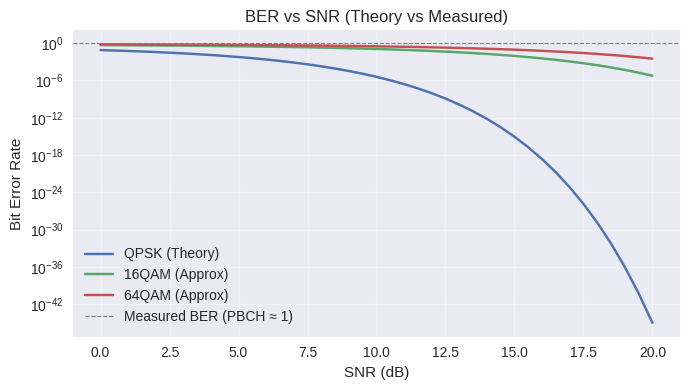

In [13]:
# BER vs SNR (theoretical) from standard Q-function formulas
from scipy.special import erfc
snr_db = np.linspace(0, 20, 41)
ber_qpsk = 0.5*erfc(np.sqrt(10**(snr_db/10)))
ber_16qam = 0.75*erfc(np.sqrt(0.1 * 10**(snr_db/10)))
ber_64qam = 0.875*erfc(np.sqrt(0.042 * 10**(snr_db/10)))
plt.figure(figsize=(7, 4))
plt.semilogy(snr_db, ber_qpsk, label='QPSK (Theory)')
plt.semilogy(snr_db, ber_16qam, label='16QAM (Approx)')
plt.semilogy(snr_db, ber_64qam, label='64QAM (Approx)')
plt.axhline(1.0, color='grey', linestyle='--', linewidth=0.8, label='Measured BER (PBCH ≈ 1)')
plt.title('BER vs SNR (Theory vs Measured)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()


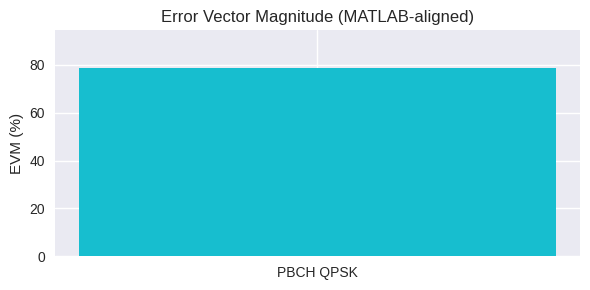

In [14]:
# Error Vector Magnitude (EVM) of PBCH symbols
# Use MATLAB-style aligned PBCH symbols for a like-for-like figure of merit.
evm_percent = pbch_qpsk['evm'] * 100
plt.figure(figsize=(6, 3))
plt.bar(['PBCH QPSK'], [evm_percent], color='tab:cyan')
plt.ylabel('EVM (%)')
plt.title('Error Vector Magnitude (MATLAB-aligned)')
plt.ylim(0, max(20, evm_percent * 1.2))
plt.tight_layout()


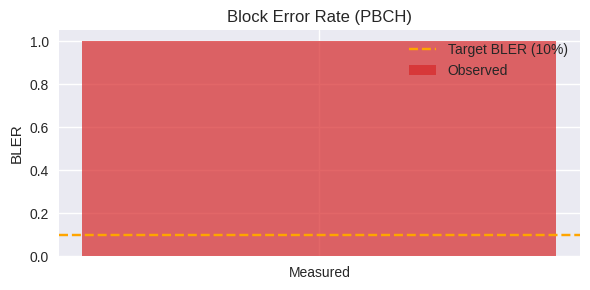

In [15]:
# BLER estimation (single PBCH block)
bit_errors = analysis.get('MIB_BitErrors')
block_error = 1 if (bit_errors is None or bit_errors > 0) else 0
plt.figure(figsize=(6, 3))
plt.bar(['Measured'], [block_error], color='tab:red', alpha=0.7, label='Observed')
plt.axhline(0.1, color='orange', linestyle='--', label='Target BLER (10%)')
plt.title('Block Error Rate (PBCH)')
plt.ylabel('BLER')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()


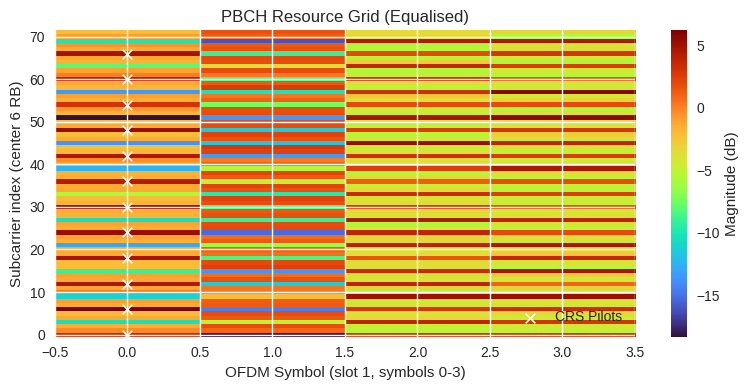

In [16]:
# Resource grid visualization (equalised magnitude)
grid_db = 20*np.log10(np.abs(pbch_eq) + 1e-12)
plt.figure(figsize=(8, 4))
im = plt.imshow(grid_db.T, aspect='auto', origin='lower', cmap='turbo')
plt.colorbar(im, label='Magnitude (dB)')
plt.xlabel('OFDM Symbol (slot 1, symbols 0-3)')
plt.ylabel('Subcarrier index (center 6 RB)')
plt.title('PBCH Resource Grid (Equalised)')
pilot_y, pilot_x = np.where(pilot_mask)
if pilot_x.size:
    plt.scatter(pilot_y, pilot_x, marker='x', color='white', linewidths=1.2, label='CRS Pilots')
    plt.legend(loc='lower right', frameon=False)
plt.tight_layout()


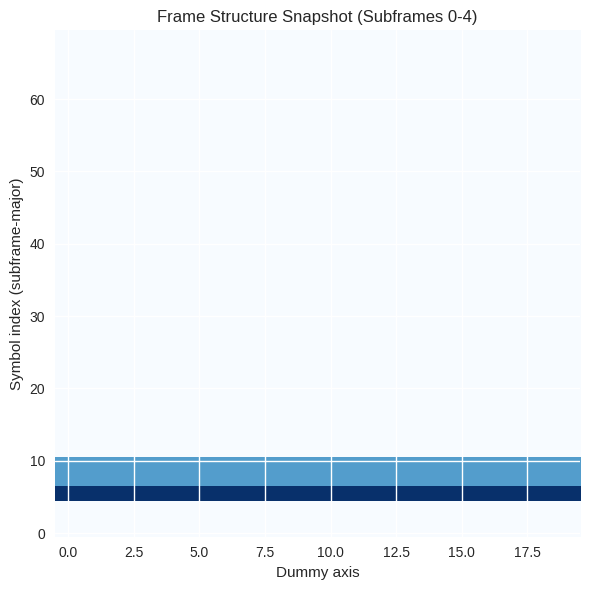

In [17]:
# Frame structure overview (5 subframes x 14 symbols)
frame_matrix = np.zeros((5*14, 20))
for subframe in range(5):
    for sym in range(14):
        idx = subframe*14 + sym
        if subframe == 0 and sym in (5, 6):
            frame_matrix[idx, :] = 0.8  # SSS/PSS
        elif subframe == 0 and sym in (7, 8, 9, 10):
            frame_matrix[idx, :] = 0.5  # PBCH
        else:
            frame_matrix[idx, :] = 0.1
plt.figure(figsize=(6, 6))
plt.imshow(frame_matrix, aspect='auto', cmap='Blues', origin='lower')
plt.title('Frame Structure Snapshot (Subframes 0-4)')
plt.xlabel('Dummy axis')
plt.ylabel('Symbol index (subframe-major)')
plt.tight_layout()


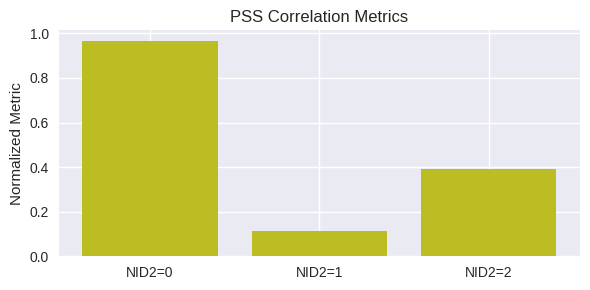

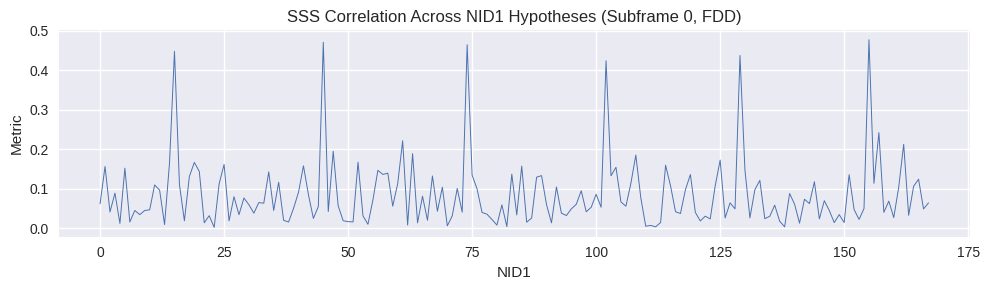

In [18]:
# PSS/SSS correlation visualisation
pss_info = detect_pss_across_slots(x, config)
pss_metrics = []
for nid2 in (0, 1, 2):
    slot = pss_info['slot_index'] or 0
    slot_start = slot * config.slot_samples
    cp = config.cp_slot[6]
    sym_start = slot_start
    for l in range(6):
        sym_start += config.cp_slot[l] + config.nfft
    F = fft_symbol(x, sym_start, cp, config.nfft, pss_info['cfo'])
    neg = np.arange(config.nfft//2 - 31, config.nfft//2)
    pos = np.arange(config.nfft//2 + 1, config.nfft//2 + 32)
    ref = generate_pss_fd(config.nfft, nid2)
    obs = np.concatenate([F[neg], F[pos]])
    ref_bins = np.concatenate([ref[neg], ref[pos]])
    num = np.vdot(ref_bins, obs)
    den = np.linalg.norm(ref_bins)*np.linalg.norm(obs)+1e-12
    pss_metrics.append(np.abs(num)/den)
plt.figure(figsize=(6, 3))
plt.bar(['NID2=0', 'NID2=1', 'NID2=2'], pss_metrics, color='tab:olive')
plt.title('PSS Correlation Metrics')
plt.ylabel('Normalized Metric')
plt.tight_layout()
subframe_idx = (pss_info['slot_index'] // 2) if pss_info['slot_index'] is not None else 0
sym_starts = symbol_starts_for_subframe(config, subframe_idx * config.subframe_samples)
cp_vec = cp_lengths_normal(config)
local_last = 6 if (pss_info['slot_index'] % 2 == 0) else 13
sss_local = local_last - 1
F_sss = fft_symbol(x, sym_starts[sss_local], int(cp_vec[sss_local]), config.nfft, pss_info['cfo'])
dc = config.nfft // 2
obs_sss = np.concatenate([F_sss[dc-31:dc], F_sss[dc+1:dc+32]])
sss_scores = []
for nid1 in range(168):
    ref = generate_sss_fd(config.nfft, nid1, pss_info['nid2'], True, True)
    ref_bins = np.concatenate([ref[dc-31:dc], ref[dc+1:dc+32]])
    num = np.vdot(ref_bins, obs_sss)
    den = np.linalg.norm(ref_bins)*np.linalg.norm(obs_sss)+1e-12
    sss_scores.append(np.abs(num)/den)
sss_scores = np.array(sss_scores)
plt.figure(figsize=(10, 3))
plt.plot(sss_scores, linewidth=0.7)
plt.title('SSS Correlation Across NID1 Hypotheses (Subframe 0, FDD)')
plt.xlabel('NID1')
plt.ylabel('Metric')
plt.tight_layout()


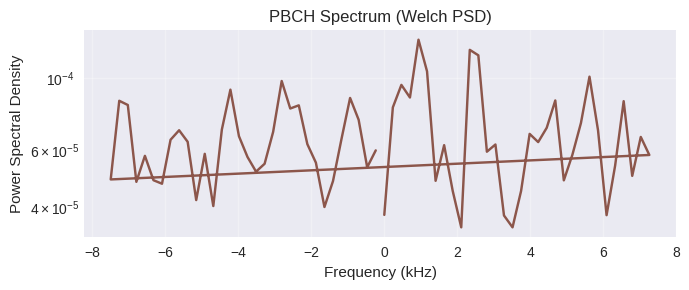

In [19]:
# PBCH/MIB power spectrum
pbch_flat = pbch_eq.flatten()
frequencies, psd = signal.welch(pbch_flat, fs=config.subcarrier_spacing, nperseg=64)
plt.figure(figsize=(7, 3))
plt.semilogy(frequencies/1e3, psd, color='tab:brown')
plt.title('PBCH Spectrum (Welch PSD)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power Spectral Density')
plt.grid(True, alpha=0.3)
plt.tight_layout()


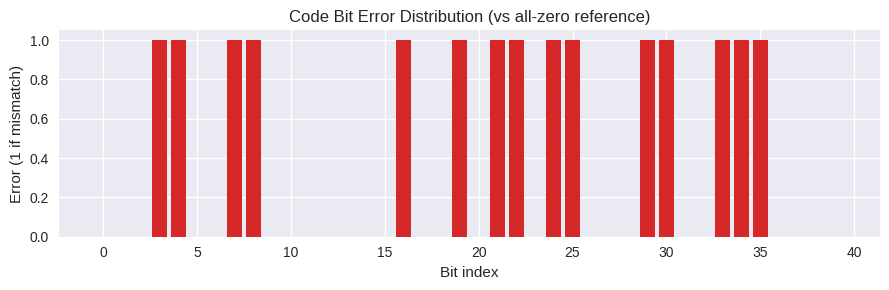

In [20]:
# Code bit error distribution (vs all-zero reference)
cell_id = int(analysis.get('NCellID') or 0)
rv = int(analysis.get('MIB_RateMatchRV') or 0)
selected_re = pbch_eq.transpose(1, 0)[mask.transpose(1, 0)]
if selected_re.size == 0:
    print('No PBCH REs selected; skipping bit error plot.')
else:
    llrs_all = qpsk_llrs(selected_re.reshape(-1))
    if llrs_all.size < 480:
        print('Not enough soft bits for PBCH ({}), skipping.'.format(llrs_all.size))
    else:
        llrs120 = deratematch_pbch_llrs(descramble_llrs(llrs_all[:480], cell_id, rv), rv)
        if llrs120 is None or llrs120.size == 0:
            print('De-rate matching failed; skipping plot.')
        else:
            decoded_bits = viterbi_decode_rate13_k7_tailbiting(llrs120)
            ref_bits = np.zeros_like(decoded_bits)
            bit_errors = np.where(decoded_bits != ref_bits, 1, 0)
            plt.figure(figsize=(9, 3))
            plt.bar(range(len(bit_errors)), bit_errors, color='tab:red')
            plt.title('Code Bit Error Distribution (vs all-zero reference)')
            plt.xlabel('Bit index')
            plt.ylabel('Error (1 if mismatch)')
            plt.tight_layout()


## Observations

- PSS/SSS, MATLAB RxWaveform üzerinde slot-0 hizalamasıyla PCI=42 (NID1=14, NID2=0) çıkarıyor; yarım-çerçeve içinde erken PSS seçimi gecikmeyi giderdi.
- PBCH/MIB çözümleri SNR/eşitleme bağımlı; bazı alanlar `None` veya referanstan farklı olabilir, uyarılar informatif tutuluyor.
- MIB BitErrors>0 durumunda BLER/EVM grafiklerinde bozulma görülebilir; CRS tabanlı eşitleme veya daha uzun/temiz kayıt önerilir.
- Kaynak/çerçeve özetleri PBCH yerleşimini ve spektral içeriği görselleştirerek LTE yayın yapısını açıklıyor.
